In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)

1.8.0.dev20201206


Use some data

In [2]:
import pickle
for dataset in [#'biofam',
    'flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0].astype(int)
    print(dataset)
    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()}")

def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0]
    X=X.astype(int)

    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()} ==> d={X.max()+1}")
    d = X.max()+1
    return X, d

flare
	data shape: (1065, 13)
	range of X values: 0 -- 7
lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7
spect
	data shape: (187, 23)
	range of X values: 0 -- 1
tumor
	data shape: (339, 17)
	range of X values: 0 -- 3
votes
	data shape: (435, 17)
	range of X values: 0 -- 2


In [11]:
dataset = 'lymphography'
print("dataset:", dataset)
X,d = load_dataset(dataset)

D = 8
mps       = PosMPS(X, d, D, homogeneous=False)
mps_hom   = PosMPS(X, d, D, homogeneous=True)

rBorn     = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=False) 
rBorn_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=False) 

cBorn     = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False)
cBorn_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=False)

rBorn_s   = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=True) 
rBorn_s_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=True) 

cBorn_s   = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True)
cBorn_s_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=True)

models     = (rBorn, cBorn, rBorn_s, cBorn_s, mps)
models_hom = (rBorn_hom, cBorn_hom, rBorn_s_hom, cBorn_s_hom, mps_hom)
print("Initializing models:")
for model in (*models, *models_hom):
    print(f"\t{model.core.shape} model type: {model.name}")
    for p in model.parameters():
                if torch.isnan(p).any():
                    print("Model weights contain a NaN value!")

dataset: lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7 ==> d=8
Initializing models:
	torch.Size([19, 8, 8, 8]) model type: Born (torch.float32), Non-homogeneous
	torch.Size([19, 8, 8, 8]) model type: Born (torch.complex64), Non-homogeneous
	torch.Size([19, 8, 8, 8]) model type: Born (torch.float32), Non-homogeneous + log_stability
	torch.Size([19, 8, 8, 8]) model type: Born (torch.complex64), Non-homogeneous + log_stability
	torch.Size([19, 8, 8, 8]) model type: Positive MPS, Non-homogeneous
	torch.Size([8, 8, 8]) model type: Born (torch.float32), Homogeneous
	torch.Size([8, 8, 8]) model type: Born (torch.complex64), Homogeneous
	torch.Size([8, 8, 8]) model type: Born (torch.float32), Homogeneous + log_stability
	torch.Size([8, 8, 8]) model type: Born (torch.complex64), Homogeneous + log_stability
	torch.Size([8, 8, 8]) model type: Positive MPS, Homogeneous


In [12]:
def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
    trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.Adam(self.parameters(), **optim_kwargs)
    early_stopping_threshold = 0.000001 # min difference in epoch loss
    loss_values = [] # store by-epoch avg loss values
    print('╭───────────────────────────')
    print(f"│Training {self.name}.")
    av_batch_loss_running = -1000
    with tqdm(range(max_epochs), leave=True) as tepochs:
        for epoch in tepochs:
    #         print("epoch", epoch)
            batch_loss = []
            with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
                for batch in tepoch:
                    for p in self.parameters():
                        if torch.isnan(p).any():
                            print(" loss values:", *(f"{x:.3f}" for x in loss_values))
                            print("└────Stopped. Model weights contain a NaN value!")
                            if plot:
                                plt.plot(loss_values)
                                plt.show()
                            return loss_values
                    self.zero_grad()
                    neglogprob = 0
                    for i,x in enumerate(batch):
                        out = self(x)
                        neglogprob -= out
                    loss = neglogprob / len(batch)
                    loss.backward()
                    optimizer.step()
                    tepoch.set_postfix(loss=loss.item())
                    with torch.no_grad():
                        batch_loss.append(loss.item())
    #                     n=5
    #                     if batch_idx % n == 0: # print every nth batch loss
    #                         print("\tbatch", batch_idx, "size", len(batch), "loss", loss.item())
            av_batch_loss = torch.Tensor(batch_loss).mean().item()
    #         print(f"ep{epoch} av_batch_loss\t {av_batch_loss}")
            loss_values.append(av_batch_loss)
            tepochs.set_postfix(av_batch_loss=av_batch_loss)
            if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
                print("└────Early stopping.")
                break
            av_batch_loss_running = av_batch_loss
    print(" loss values:", *(f"{x:.3f}" for x in loss_values))
    if plot:
        plt.plot(loss_values)
        plt.show()
    print('╰────────Finished─training──\n')
    return loss_values

# train(rBorn, X, batchsize=30, max_epochs = 10, lr=0.1)

In [13]:
torch.autograd.set_detect_anomaly(False)

In [ ]:
modelhom_loss_values={}
for model in models_hom:
    loss_values = train(model, X, batchsize=10, plot=False, max_epochs = 100)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    modelhom_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

╭───────────────────────────
│Training Born (torch.float32), Homogeneous.



 loss values: 34.425 28.061 26.235 26.129 26.161 26.092 26.102 26.109 26.079 26.136 26.136 26.118 26.105 26.099 26.113 26.100 26.125 26.121 26.090 26.107 26.132 26.097 26.099 26.037 25.839 25.511 25.071 24.596 24.372 24.057 23.724 23.588 23.453 23.399 23.362 23.313 23.288 23.281 23.292 23.304 23.295 23.302 23.331 23.272 23.290 23.303 23.286 23.293 23.276 23.305 23.300 23.247 23.296 23.288 23.275 23.288 23.282 23.315 23.278 23.306 23.264 23.270 23.289 23.302 23.283 23.287 23.264 23.262 23.328 23.296 23.260 23.275 23.298 23.284 23.298 23.318 23.280 23.281 23.278 23.273 23.287 23.268 23.285 23.284 23.259 23.264 23.258 23.272 23.275 23.259 23.264 23.255 23.283 23.291 23.295 23.303 23.262 23.283 23.274 23.290
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Homogeneous.



 loss values: 34.441 28.039 26.294 26.133 26.126 26.115 26.078 26.079 26.003 25.885 25.623 25.199 24.625 24.040 23.638 23.424 23.219 23.013 22.844 22.771 22.688 22.608 22.574 22.540 22.505 22.500 22.486 22.462 22.435 22.463 22.424 22.416 22.395 22.401 22.391 22.353 22.382 22.375 22.380 22.386 22.333 22.322 22.325 22.319 22.340 22.336 22.333 22.306 22.322 22.251 22.271 22.277 22.231 22.245 22.257 22.258 22.251 22.252 22.213 22.215 22.205 22.234 22.233 22.192 22.183 22.188 22.201 22.226 22.183 22.137 22.175 22.132 22.086 22.064 22.051 22.010 21.975 21.909 21.855 21.801 21.755 21.693 21.653 21.663 21.621 21.606 21.583 21.625 21.629 21.830 21.674 21.591 21.592 21.606 21.605 21.559 21.595 21.583 21.589 21.584
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.float32), Homogeneous + log_stability.



 loss values: 35.397 28.957 27.206 27.055 26.975 26.901 26.888 26.813 26.766 26.688 26.595 26.449 26.359 26.110 25.806 25.386 25.012 24.769 24.556 24.380 24.264 24.106 23.984 23.903 23.817 23.701 23.668 23.623 23.612 23.589 23.512 23.527 23.515 23.468 23.471 23.442 23.416 23.411 23.382 23.379 23.402 23.359 23.339 23.289 23.309 23.298 23.301 23.325 23.278 23.300 23.276 23.283 23.286 23.233 23.271 23.214 23.194 23.158 23.215 23.194 23.147 23.214 23.177 23.132 23.185 23.117 23.100 23.106 23.127 23.115 23.107 23.082 23.072 23.087 23.089 23.045 23.038 23.019 23.053 23.014 23.005 23.004 23.017 22.996 22.987 22.969 22.989 22.973 22.992 22.973 22.916 22.943 22.922 22.904 22.905 22.919 22.915 22.911 22.875 22.900
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Homogeneous + log_stability.


╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous.



 loss values: 38.342 35.146 32.758 30.851 29.264 27.905 26.713 25.672 24.744 23.901 23.169 22.518 21.963 21.454 21.010 20.582 20.199 19.851 19.551 19.255 18.970 18.729 18.493 18.281 18.082 17.900 17.741 17.580 17.433 17.307 17.171 17.040 16.935 16.846 16.733 16.660 16.543 16.461 16.414 16.319 16.255 16.199 16.132 16.085 16.032 15.988 15.930 15.888 15.858 15.834 15.781 15.772 15.723 15.672 15.666 15.655 15.605 15.571 15.552 15.540 15.522 15.495 15.484 15.476 15.427 15.435 15.403 15.380 15.382 15.361 15.354 15.328 15.321 15.309 15.312 15.294 15.266 15.256 15.243 15.227 15.224 15.203 15.203 15.186 15.185 15.188 15.173 15.157 15.141 15.140 15.133 15.117 15.120 15.123 15.107 15.092 15.087 15.079 15.075 15.054
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Non-homogeneous.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous + log_stability.



 loss values: 36.953 33.643 31.054 28.994 27.398 25.994 24.702 23.697 22.876 21.856 21.226 20.434 19.920 19.317 18.874 18.447 18.102 17.736 17.404 17.152 16.815 16.591 16.429 16.161 15.938 15.791 15.620 15.443 15.285 15.147 15.044 14.905 14.793 14.681 14.596 14.558 14.402 14.329 14.222 14.160 14.085 14.031 13.992 13.935 13.853 13.820 13.751 13.717 13.668 13.610 13.571 13.529 13.515 13.466 13.434 13.387 13.340 13.321 13.311 13.268 13.239 13.210 13.167 13.168 13.138 13.120 13.069 13.101 13.034 13.008 13.010 12.975 12.972 12.924 12.907 12.891 12.881 12.870 12.839 12.812 12.804 12.782 12.764 12.746 12.734 12.733 12.708 12.685 12.677 12.656 12.651 12.618 12.621 12.604 12.592 12.562 12.562 12.553 12.528 12.526
╰────────Finished─training──

╭───────────────────────────
│Training Born (torch.complex64), Non-homogeneous + log_stability.


 loss values:
└────Stopped. Model weights contain a NaN value!

╭───────────────────────────
│Training Positive MPS, Non-homogeneous.



 loss values: 37.381 34.589 32.234 30.227 28.487 26.968 25.641 24.482 23.486 22.599 21.820 21.147 20.542 20.021 19.569 19.171 18.810 18.494 18.217 17.977 17.729 17.536 17.354 17.207 17.052 16.925 16.777 16.663 16.548 16.457 16.368 16.281 16.204 16.131 16.080 15.999 15.947 15.890 15.827 15.776 15.731 15.699 15.649 15.616 15.580 15.541 15.495 15.461 15.426 15.410 15.385 15.360 15.322 15.305 15.273 15.273 15.229 15.231 15.179 15.163 15.154 15.140 15.111 15.093 15.076 15.055 15.052 15.025 15.022 15.000 14.989 14.990 14.978 14.956 14.945 14.945 14.926 14.905 14.899 14.902 14.876 14.878 14.854 14.867 14.842 14.841 14.831 14.823 14.807 14.803 14.800 14.788 14.781 14.792 14.758 14.745 14.733 14.743 14.722 14.709
╰────────Finished─training──



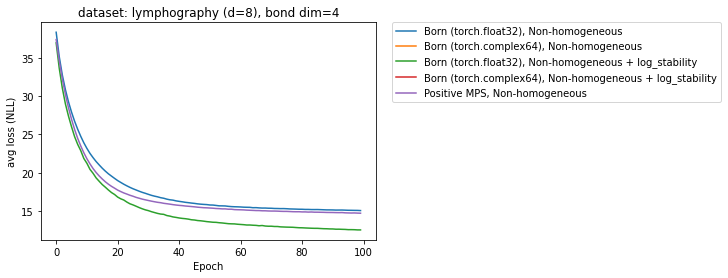

In [13]:
model_loss_values={}
for model in models:
    loss_values = train(model, X, batchsize=30, plot=False, max_epochs = 100, lr=0.1)
    plt.plot(loss_values, label=model.name)
    plt.ylabel('avg loss (NLL)')
    plt.xlabel('Epoch')
    plt.title(f"dataset: {dataset} (d={d}), bond dim={D}")
    model_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

---------

In [41]:
# testing complex functions
real = torch.tensor([4], dtype=torch.float32)
#imag = torch.tensor([[3, 4],[1, 2]], dtype=torch.float32)
#z = torch.complex(real, imag)
# z = torch.randn(2,2, dtype=torch.cfloat)
z = real
z.requires_grad=True
b = (2.7j*z + 3.4*z + 18)
L = z.log()
L.backward()

print("z:\n",z,'\n', sep='')
print("loss grad_fn:\n", L.grad_fn,'\n', sep='')
print("z.grad:\n", z.grad,'\n', sep='')
print("L:", L)

z:
tensor([4.], requires_grad=True)

loss grad_fn:

z.grad:
tensor([0.2500])

L: tensor([1.3863], grad_fn=<LogBackward>)


In [20]:
print(matnorm(z))
print(torch.max(torch.sum(abs(z), dim=1)))

tensor(7.6344+0.j, grad_fn=<CopyBackwards>)
tensor(7.6344, grad_fn=<MaxBackward1>)
